In [1]:
using Revise
using AutomotiveDrivingModels
using AutoViz
using AutomotiveSensors
using AutomotivePOMDPs
using GridInterpolations

using POMDPPolicies

using JLD2
using FileIO
using Reel
using Random
using POMDPs
using POMDPModelTools
using LinearAlgebra

using PedestrianAvoidancePOMDP
using EmergencyBrakingSystem

using Plots
import PGFPlots

┌ Info: Precompiling PedestrianAvoidancePOMDP [a80ff0fe-e6a0-11e8-3b05-15413bd5ea7a]
└ @ Base loading.jl:1273
  ** incremental compilation may be fatally broken for this module **

┌ Warning: C:\Users\Maxime\.julia\packages\Plots\WwFyB\src\Plots.jl\ is not an existing directory, Revise is not watching
└ @ Revise C:\Users\Maxime\.julia\packages\Revise\2NCCI\src\Revise.jl:488


In [4]:
# 1) choose which algorithm 
#algorithm = "EmergencyBrakingSystem"
#algorithm = "PedestrianAvoidancePOMDP"
algorithm = "PedestrianAvoidancePOMDP_EmergencyBrakingSystem"


# 2) load policy
policy = load("../policy/policy.jld2")["policy"];
#policy = load("../policy/lateral2_-600.0_0.3_-1.0_-100.0_20.0_10.0_0.95_.jld2")["policy"];
#policy = load("../policy/longitudinal_-600.0_0.4_0.0_0.0_30.0_0.0_0.95_.jld2")["policy"];


# Definition ego vehicle and pedestrian behavior
scenarios = ["CPCN", "CPAN25", "CPAN75", "CPFA", "FP"]
vut_speeds = [10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60.]
vut_speeds = vut_speeds / 3.6
hit_points = [0., 10., 20., 30., 40., 50.]

ego_v = vut_speeds[9]
hit_point = hit_points[3]


# 3) choose scenario, 1 -> scenerio with obstruction (CPCN), 2 -> without obstruction (CPAN25)
scenario = scenarios[1]

# 4) if no pedesstrian should be visible
#hit_point = 800.

probability_pedestrian_birth = policy.pomdp.PROBABILITY_PEDESTRIAN_BIRTH


ego_vehicle = []
ego_a = [] 
collision = []
belief = []
action_pomdp = []
collision_rate = []
ttc = []
risk = []
emergency_brake_request = []
prediction_obstacle = []

### Simulate scenario with parameters above defined
# generate scenario based on scenario type
(ego_x, ego_y, ego_v, ped_x, ped_y, ped_v, ped_theta, obstacles, scenario_id) = PedestrianAvoidancePOMDP.generate_scenario(scenario, ego_v, hit_point)
#println(ego_x, " ", ego_y, " ", ego_v, " ", ped_x," ",  ped_y," ",  ped_v)

# simulate scenario
if (algorithm == "EmergencyBrakingSystem")
    (scenes, timestep, env, sensor, sensor_observations, ego_vehicle, ego_a, collision, collision_rate, ttc, risk, emergency_brake_request, prediction_obstacle) = EmergencyBrakingSystem.evaluate_scenario(ego_x, ego_y, ego_v, ped_x, ped_y, ped_v, ped_theta, obstacles)
else
    (scenes, timestep, env, sensor, sensor_observations, ego_vehicle, ego_a, collision, belief, action_pomdp, collision_rate, ttc, risk, emergency_brake_request, prediction_obstacle) = PedestrianAvoidancePOMDP.evaluate_scenario(ego_x, ego_y, ego_v, ped_x, ped_y, ped_v, ped_theta, obstacles, policy, algorithm, probability_pedestrian_birth, [0.0])
end
#evaluate result
(collision, emergency_brake_intervention, dv_collision, v_mean, a_mean, a_jerk, a_min) = PedestrianAvoidancePOMDP.evaluateScenarioMetric(ego_vehicle, emergency_brake_request, ego_a, collision, ped_x)



PedestrianAvoidancePOMDP_EmergencyBrakingSystem


(false, true, 0.0, 10.884429824561426, -6.303921568627451, 125.0, -10.0)

In [8]:
# Visualize scenario
cam = StaticCamera(VecE2(95.0,0.0),20.0)
#cam = CarFollowCamera(1,10.0)

if (algorithm == "EmergencyBrakingSystem")
    duration, fps, render_hist = EmergencyBrakingSystem.animate_record(scenes, timestep, env, ego_vehicle, sensor, sensor_observations, risk, ttc, collision_rate, emergency_brake_request, prediction_obstacle, cam)
else
    duration, fps, render_hist = animate_record(scenes, timestep, env, sensor, sensor_observations, risk, belief, ego_vehicle, action_pomdp, prediction_obstacle, cam)
end

film = roll(render_hist, fps = fps, duration = duration)
write(string("scenario_", scenario, "_", algorithm, ".mp4"), film) # Write to a mp4 video
film

Frames{MIME{Symbol("image/png")}}("C:\\Users\\Maxime\\AppData\\Local\\Temp\\jl_f2PIjW", 0x00000000000000f1, 20.0, "scenario_CPCN_PedestrianAvoidancePOMDP_EmergencyBrakingSystem.mp4")

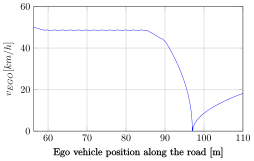

In [9]:
# store and visualize velocity and acceleration profile
v = Float64[] 
x = Float64[]
a = Float64[]
push!(v, ego_vehicle[2].state.v)
push!(x, ego_vehicle[2].state.posG.x)
push!(a, ego_a[2])

for i=2:length(ego_vehicle)
    v_tmp = v[end]*0.0 + 1.0*ego_vehicle[i].state.v
    push!(v, v_tmp) 
    push!(x, ego_vehicle[i].state.posG.x)

    push!(a, ego_a[i])
end

file_name = string(algorithm, "_CPCN_0.jld2");
@save file_name x v a;

#@load "simulation_results/PedestrianAvoidancePOMDP_EmergencyBrakingSystem_CPCN.jld2" x v a
pgfplots()


v_plot = PGFPlots.Axis(style="width=9cm, height=6cm, grid=both",  ymin=0, ymax=60, xmin=x[1], xmax=110, xlabel="Ego vehicle position along the road [m]", ylabel=L"$v_{EGO}{[}km/h{]}$")
v_ego = PGFPlots.Linear(x, v*3.6, style="blue", mark="none")
push!(v_plot, v_ego)

a_plot = PGFPlots.Axis(style="width=9cm, height=6cm, grid=both",  ymin=2, ymax=-10, xmin=x[1], xmax=110, xlabel="Ego vehicle position along the road [m]", ylabel=L"$a_{EGO}{[}m/s^2{]}$")
a_ego = PGFPlots.Linear(x, a, style="red", mark="none")
push!(a_plot, a_ego)


PGFPlots.save("velocity_profile.pdf", v_plot)
PGFPlots.save("acceleration_profile.pdf", a_plot)

v_plot